<ipython-input-11-a12f82b62b6f>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary_encoded = housing_data[categorical_features].replace({"yes": 1, "no": 0, "furnished": 2, "semi-furnished": 1, "unfurnished": 0})


Epoch 1/50, Train Loss: 1.0183, Val Loss: 1.7164
Epoch 2/50, Train Loss: 1.0092, Val Loss: 1.7043
Epoch 3/50, Train Loss: 1.0013, Val Loss: 1.6917
Epoch 4/50, Train Loss: 0.9930, Val Loss: 1.6768
Epoch 5/50, Train Loss: 0.9821, Val Loss: 1.6596
Epoch 6/50, Train Loss: 0.9724, Val Loss: 1.6432
Epoch 7/50, Train Loss: 0.9598, Val Loss: 1.6262
Epoch 8/50, Train Loss: 0.9477, Val Loss: 1.6088
Epoch 9/50, Train Loss: 0.9348, Val Loss: 1.5913
Epoch 10/50, Train Loss: 0.9237, Val Loss: 1.5732
Epoch 11/50, Train Loss: 0.9105, Val Loss: 1.5519
Epoch 12/50, Train Loss: 0.8944, Val Loss: 1.5261
Epoch 13/50, Train Loss: 0.8734, Val Loss: 1.4954
Epoch 14/50, Train Loss: 0.8506, Val Loss: 1.4593
Epoch 15/50, Train Loss: 0.8240, Val Loss: 1.4158
Epoch 16/50, Train Loss: 0.7949, Val Loss: 1.3634
Epoch 17/50, Train Loss: 0.7556, Val Loss: 1.3027
Epoch 18/50, Train Loss: 0.7074, Val Loss: 1.2336
Epoch 19/50, Train Loss: 0.6642, Val Loss: 1.1562
Epoch 20/50, Train Loss: 0.6100, Val Loss: 1.0709
Epoch 21/

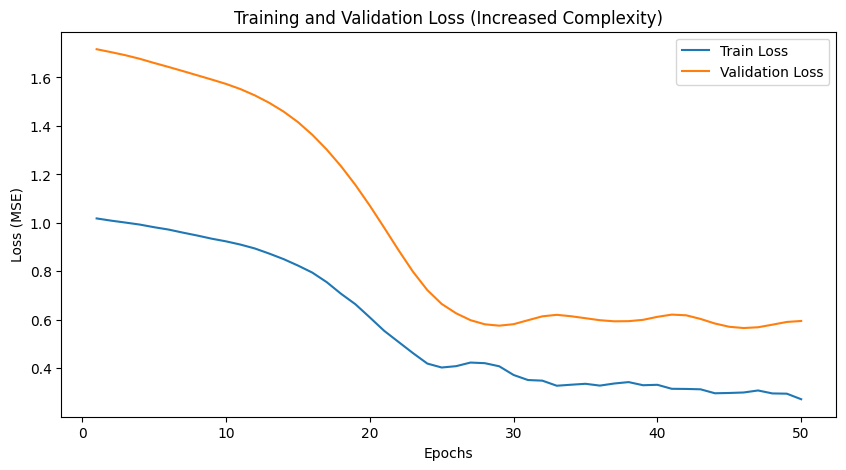

Final Mean Squared Error (MSE): 0.5953
Final Mean Absolute Error (MAE - Original Scale): 1004708.38
Final Accuracy: 79.94%
Model Complexity (Total Trainable Parameters): 46849


In [11]:
#####complexity###


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


housing_data = pd.read_csv("Housing.csv")
numerical_features = ["area", "bedrooms", "bathrooms", "stories", "parking"]
categorical_features = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "furnishingstatus"]
target = "price"


binary_encoded = housing_data[categorical_features].replace({"yes": 1, "no": 0, "furnished": 2, "semi-furnished": 1, "unfurnished": 0})



X = pd.concat([housing_data[numerical_features], binary_encoded], axis=1)
y = housing_data[target]

#train 80% and test 20% sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#numerical features and target variable
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    ####Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

   ####Define a more complex MLP model
class ComplexHousingMLP(nn.Module):
    def __init__(self, input_dim):
        super(ComplexHousingMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

#initialize the more complex model, loss function
input_dim = X_train.shape[1]
complex_model = ComplexHousingMLP(input_dim)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(complex_model.parameters(), lr=0.001)

#train the complex model
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    #training phase
    complex_model.train()
    optimizer.zero_grad()
    predictions = complex_model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    #vvalidation phase
    complex_model.eval()
    with torch.no_grad():
        val_predictions = complex_model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)

    #Save losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())


    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

###plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss (Increased Complexity)")
plt.legend()
plt.show()


####evaluate the complex model
complex_model.eval()
with torch.no_grad():
    test_predictions = complex_model(X_test_tensor)
    mse = criterion(test_predictions, y_test_tensor).item()
    mae = torch.mean(torch.abs(test_predictions - y_test_tensor)).item()

    #Convert predictions back to original scale
    test_predictions_original = scaler_y.inverse_transform(test_predictions.numpy())
    y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())
    mae_original = torch.mean(torch.abs(torch.tensor(test_predictions_original) - torch.tensor(y_test_original))).item()

     #calculate accuracy
mean_target_value = y_test_original.mean()
accuracy = 1 - (mae_original / mean_target_value)

###Report model complexity
total_params = sum(p.numel() for p in complex_model.parameters() if p.requires_grad)

#output final results
print(f"Final Mean Squared Error (MSE): {mse:.4f}")
print(f"Final Mean Absolute Error (MAE - Original Scale): {mae_original:.2f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")
print(f"Model Complexity (Total Trainable Parameters): {total_params}")
